# CS 585 Problem Set 2 (Total points: 70)

Assignment adapted from Svetlana Lazebnik.

**Instructions**
1.   Assignment is due at 11:59 PM on **Tuesday Feb 28th 2023**.
2.   Submission instructions:

     A. A single `.pdf` report that contains your work for Q1 and Q2. You can either type out your responses in LaTeX or google document. Lastly, please convert your work into a PDF.

       The PDF file should be submitted to Gradescope under PS2. Please tag the reponses in your PDF with the Gradescope questions outline as described in Submitting an Assignment.

     B. You also need to submit your code in the form of a single `.py` file in the same directory. You can convert this notebook to Python code by downloading the .ipynb file as Python(`.py`). Code should also be submitted to Gradescope under PS2-Code. Not submitting your code will lead to a loss of 100% of the points for implementation.

     C. Both Q1 and Q2 require you to evaluate your implemented models on held-out test data. You will need to submit the generated outputs ("Q1_label_predictions.npy" and "Q2_surface_predictions.npy") in the PS2-Code directory as well.

     D. We reserve the right to take off points for not following submission instructions. In particular, please tag the reponses in your PDF with the Gradescope questions outline as described in [Submitting an Assignment](https://www.youtube.com/watch?v=u-pK4GzpId0).
   

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You may be asked to copy and paste an authentication code.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls

gdrive	sample_data


# Change directory to allow imports


As noted above, you should create a Google Drive folder `My Drive/Colab Notebooks/CS_585_PS2` to hold all your assignment files. You will need to run this code to be able to import python files from the folder (you can change the file path below to be your own assignment folder).

In [ ]:
import os
if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2")
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2")

# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Make sure that pytorch is installed and works with GPU:

In [ ]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [ ]:
torch.cuda.is_available()

True

# **Q1 Part I: Cifar-10 class predictions**

Implement and improve BaseNet on CIFAR-10 [30 pts]. For this part of the assignment, you will be working with
the CIFAR-10 dataset. This dataset consists of 60K 32 × 32 color images from
10 classes. There are 50K training images and 10K validation images. The images in CIFAR-10 are of size
3 × 32 × 32, i.e. three-channel RGB images of 32 × 32 pixels.

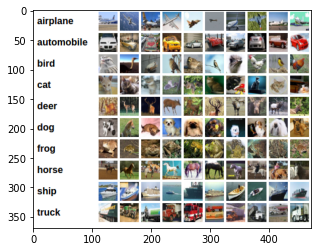

In [ ]:
from IPython.display import display
from PIL import Image
import matplotlib.figure
import matplotlib.pyplot as plt

plt.imshow(Image.open("cifar10.png"))

In [ ]:
# imports and useful functions

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import copy
import csv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
from tqdm.notebook import tqdm
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class CIFAR10Test(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None,
    ):
        super(CIFAR10Test, self).__init__(root, transform=transform)

        image_filename = os.path.join(root, 'cifar10_test_images.npy')
        images = np.load(image_filename)

        assert len(images.shape) == 4
        assert images.shape[0] == 2000
        assert images.shape[1] == 32
        assert images.shape[2] == 32
        assert images.shape[3] == 3

        self.data = images

    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


def calculate_accuracy(dataloader, model, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        dataloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    # Check out why .eval() is important!
    # https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
    model.eval()

    with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if is_gpu:
              images = images.cuda()
              labels = labels.cuda()
          outputs = model(Variable(images))
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(list(predicted.cpu().numpy()))
          total += labels.size(0)
          correct += (predicted == labels).sum()

          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].cpu()
              class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy


def run_secret_test(dataloader, model, is_gpu):
    predictions = []
    model.eval()

    with torch.no_grad():
      for images in dataloader:
          if is_gpu:
              images = images.cuda()
          outputs = model(Variable(images))
          predicted = torch.softmax(outputs, dim=1).cpu().numpy()
          predictions.extend(list(predicted))
        
    return predictions



Q1 Part II : Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the randomized CIFAR10 training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   images.
2. Define a Convolution Neural Network - BaseNet.
3. Define a loss function and optimizer.
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create `.npy` file for submission to Gradescope.

In [ ]:
import os
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2


In [ ]:
# <<TODO>>: Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 15
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 10
TRAIN_BS = 32
PATH_TO_CIFAR10 = "data/cifar10/"
PATH_TO_CIFAR10_TEST = "/content/gdrive/MyDrive/Colab Notebooks/CS_585_PS2/data/cifar10"

1.**Loading CIFAR-10 [x pts]** 

We will load the CIFAR-10 dataset with builtin dataset loader from Torchvision. The train, validation and test splits are [here](https://drive.google.com/file/d/1vAh-vUr58_f-WSj38VVXQD7Xve-NkSa6/view?usp=share_link). Upload the `zip` file to colab.

In [ ]:
!unzip -qqo /content/gdrive/MyDrive/Colab\ Notebooks/CS_585_PS2/cifar10_splits.zip

In [ ]:

train_transform = transforms.Compose(
    [transforms.ToTensor()])

print(train_transform)
test_transform = transforms.Compose(
    [transforms.ToTensor()])

Compose(
    ToTensor()
)


In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to 
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------
# <<TODO#1>>
train_transform = transforms.Compose( 
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225]),
     transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip()
     ])

print(type(train_transform))
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225]),
     transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip()
     ])
# ---------------------

#DO NOT CHANGE any line below
train_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=False, download=False, transform=test_transform)
test_dataset = CIFAR10Test(root=PATH_TO_CIFAR10_TEST, transform=test_transform)

val_dataset.data = np.load("cifar10_splits/cifar10_val_images.npy")
val_dataset.targets = np.load("cifar10_splits/cifar10_val_labels.npy")
test_dataset.data = np.load("cifar10_splits/cifar10_test_images.npy")

print("train_dataset data shape: ", np.array(train_dataset.data).shape)
print("train_dataset labels shape: ", np.array(train_dataset.targets).shape)
print()
print("val_dataset data shape: ", np.array(val_dataset.data).shape)
print("val_dataset labels shape:", np.array(val_dataset.targets).shape)

# check for Dataloader function: https://pytorch.org/docs/stable/data.html
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)
# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE

# The 10 classes for FashionMNIST
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

<class 'torchvision.transforms.transforms.Compose'>
Files already downloaded and verified
train_dataset data shape:  (50000, 32, 32, 3)
train_dataset labels shape:  (50000,)

val_dataset data shape:  (8000, 32, 32, 3)
val_dataset labels shape: (8000,)


2.**Visualize CIFAR-10**

We will visualize some random images from the CIFAR-10 dataset.

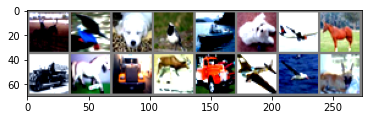

horse  bird   dog  bird  ship   dog airplane horse truck horse truck  deer truck airplane  bird   dog


In [ ]:
# Let us show some of the training images, for fun.
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

**a. Implement BaseNet [5 pts]**. Implement the BaseNet with the neural network shown below. The starter code for this is in the BaseNet class. After implementing the BaseNet class, you can run the code with default settings to get a baseline accuracy of around 60% on the validation set. The BaseNet is built with following components: 

- Convolutional, i.e. nn.Conv2d

- Pooling, e.g. nn.MaxPool2d

- Fully-connected (linear), i.e. nn.Linear

- Non-linear activations, e.g. nn.ReLU BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

In your report, include your model by using Python print command print(net) and final accuracy on the validation set. We allocate **3 out of 5 points** for the implementation part and the **remaining 2** for reporting your base model and the accuracy on the validation set.

3.**Define a Convolution Neural Network [x pts]**

Implement the BaseNet exactly. BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

| Layer No.   | Layer Type  | Kernel Size | Input Dim   | Output Dim  | Input Channels | Output Channels |
    | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
    | 1 | conv2d | 5 | 32 | 28 | 3 | 6 |
    | 2 | relu | - | 28 | 28 | 6 | 6 |
    | 3 | maxpool2d | 2 | 28 | 14 | 6 | 6 |
    | 4 | conv2d | 5 | 14 | 10 | 6 | 16 |
    | 5 | relu | - | 10 | 10 | 16 | 16 |
    | 6 | maxpool2d | 2 | 10 | 5 | 16 | 16 |
    | 7 | linear | - | 1 | 1 | 400 | 200 |
    | 8 | relu | - | 1 | 1 | 200 | 200 |
    | 9 | linear | - | 1 | 1 | 200 | 10 |

In [ ]:
# ########################################################################
# # We provide a basic network that you should understand, run and
# # eventually improve
# # <<TODO>> Add more conv layers
# # <<TODO>> Add more fully connected (fc) layers
# # <<TODO>> Add regularization layers like Batchnorm.
# #          nn.BatchNorm2d after conv layers:
# #          http://pytorch.org/docs/master/nn.html#batchnorm2d
# #          nn.BatchNorm1d after fc layers:
# #          http://pytorch.org/docs/master/nn.html#batchnorm1d
# # This is a good resource for developing a CNN for classification:
# # http://cs231n.github.io/convolutional-networks/#layers

# import torch.nn as nn
# import torch.nn.functional as F



class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # TODO: define your model here
        self.relu   = nn.ReLU()
        # nn.Conv2d(input channle dimension, output channel dimension, filter_size)
        
        # Channel: 3, input size = 32
        self.conv1  = nn.Conv2d(3, 6, 5)
        self.norm1  = nn.BatchNorm2d(6)

        self.pool1  = nn.MaxPool2d(2, stride=2)

        # ---------------------------------------#
        self.conv2  = nn.Conv2d(6, 16, 5)
        self.norm2  = nn.BatchNorm2d(16)

        self.pool2  = nn.MaxPool2d(2, stride=2)
        self.fc1    = nn.Linear(400, 200)
        self.norm4  = nn.BatchNorm1d(200)

        self.fc2    = nn.Linear(200,10)

    def forward(self, x):

        # TODO: define your model here
        bs, _, _, _ = x.shape
        # ---------------------------------------#
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool1(x)
        # ---------------------------------------#
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(bs, -1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.norm4(x)
        x = self.fc2(x)


        return x

# # Create an instance of the nn.module class defined above:
net = BaseNet()

# # Test your BaseNet with some random input
dummy_input = torch.rand((2, 3, 32, 32))
output = net(dummy_input)
# # assert output.shape == torch.Size([1, 10])

# # For training on GPU, we need to transfer net and data onto the GPU
# # http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


In [ ]:
########################################################################
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

# class convN(nn.Module):
#     def __init__(self, in_chan, out_chan, filter):
#         super(BaseNet, self).__init__()
#         self.relu   = nn.ReLU()
#         self.conv  = nn.Conv2d(in_chan, out_chan, filter)
#         self.norm  = nn.BatchNorm2d(out_chan)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.norm(x)
#         x = self.relu(x)
#         return x

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # TODO: define your model here
        self.relu   = nn.ReLU()
        # nn.Conv2d(input channle dimension, output channel dimension, filter_size)
        
        # Channel: 3, input size = 32
        self.conv1  = nn.Conv2d(3, 6, 3)
        self.norm1  = nn.BatchNorm2d(6)

        self.conv1_2  = nn.Conv2d(6, 12, 3)
        self.norm1_2  = nn.BatchNorm2d(12)

        self.pool1  = nn.MaxPool2d(2, stride=2)

        # ---------------------------------------#
        self.conv2  = nn.Conv2d(12, 24, 3)
        self.norm2  = nn.BatchNorm2d(24)

        self.conv2_2  = nn.Conv2d(24, 48, 3)
        self.norm2_2  = nn.BatchNorm2d(48)

        self.pool2  = nn.MaxPool2d(2, stride=2)

        # ---------------------------------------#
        # self.conv3  = nn.Conv2d(48, 96, 2)
        # self.norm3  = nn.BatchNorm2d(96)

        # self.conv3_2  = nn.Conv2d(96, 192, 2)
        # self.norm3_2  = nn.BatchNorm2d(96)

        # self.pool3  = nn.MaxPool2d(2, stride=2)

        # ---------------------------------------#
        self.fc1    = nn.Linear(1200, 400)
        self.norm4  = nn.BatchNorm1d(400)

        self.fc2    = nn.Linear(400,100)

        self.norm5  = nn.BatchNorm1d(100)

        self.fc3    = nn.Linear(100,10)



    def forward(self, x):

        # TODO: define your model here
        bs, _, _, _ = x.shape
        # print(x.shape)
        # ---------------------------------------#
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        # print(" conv1: ", x.shape)


        x = self.conv1_2(x)
        x = self.norm1_2(x)
        x = self.relu(x)
        # print(" conv1_2: ", x.shape)


        x = self.pool1(x)
        # print(x.size())
        # torch.Size([1, 6, 28, 28])

        # ---------------------------------------#

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        # print(" conv2: ", x.size())


        x = self.conv2_2(x)
        x = self.norm2_2(x)
        x = self.relu(x)
        # print(" conv2_2: ", x.size())

        x = self.pool2(x)
        # print(x.size())

        # ---------------------------------------#
        # x = self.conv3(x)
        # x = self.norm3(x)
        # x = self.relu(x)

        # x = self.conv3_2(x)
        # x = self.norm3_2(x)
        # x = self.relu(x)

        # x = self.pool3(x)

        # print(x.size())

        # ---------------------------------------#
        x = x.view(bs, -1)
        # print(" flatten: ", x.size())

        x = self.fc1(x)
        x = self.norm4(x)
        x = self.relu(x)
        

        x = self.fc2(x)
        x = self.norm5(x)
        x = self.relu(x)

        x = self.fc3(x)
        # x = self.relu(x)
        # x = self.norm5(x)

        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# Test your BaseNet with some random input
dummy_input = torch.rand((2, 3, 32, 32))
output = net(dummy_input)
# assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


**b. Improve BaseNet [20 pts]**. Your goal is to edit the BaseNet class or make new classes for devising a more accurate deep net architecture.  In your report, you will need to include a table similar to the one above to illustrate your final network.
Before you design your own architecture, you should start by getting familiar with the BaseNet architecture already provided, the meaning of hyper-parameters and the function of each layer. This tutorial by PyTorch is helpful for gearing up on using deep nets. Also, see Andrej Karpathy's lectures on CNNs and neural network training. For improving the network, you should consider the following aspects. In addition, you can also try out your own ideas. Since Colab makes only limited computational resources available, we encourage you to rationally limit training time and model size. Do not simply just copy over model architectures from the Internet.

- Data normalization. Normalizing input data makes training easier and more robust. You can normalize the data to made it zero mean and fixed standard deviation (σ=1\sigma = 1σ=1 is the go-to choice).  You may use transforms.Normalize() with the right parameters for this data normalization. After your edits, make sure that test_transform has the same data normalization parameters as train_transform.

- Data augmentation. Augment the training data using random crops, horizontal flips, etc. You may find functions transforms.RandomCrop(), transforms.RandomHorizontalFlip() useful. Remember, you shouldn't augment data at test time. You may find the PyTorch tutorial on transforms useful.

- Deeper network. Experiment by adding more convolutional and fully connected layers. Add more convolutional layers with increasing output channels and also add more linear (fully convolutional) layers.

- Normalization layers. Normalization layers may help reduce overfitting and improve training of the model. Add normalization layers after conv layers (nn.BatchNorm2d). Add normalization layers after linear layers and experiment with inserting them before or after ReLU layers (nn.BatchNorm1d).

In your report, include:

Your best model. Include final accuracy on validation set, table defining your final architecture (similar to the BaseNet table above), training loss plot and val accuracy plot for final model (auto-generated by the notebook). A reasonable submission with more than 85% accuracy will be given full credit for this part. An ablation table, listing all factors that you tried to make improvement to your final model as well as the corresponding validation accuracy.

We will allocate **15 out of 20** points for the implementation and the **remaining 5** points for the write-up.

In [ ]:
# TODO: paste output in your report
print(net)

BaseNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (norm1_2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm2_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=400, bias=True)
  (norm4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, ou

4.**Define a loss function and optimizer**

In [ ]:
########################################################################
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.)

# learning rate: 0.01; epoch: 9, 63.2
# learning rate: 0.001; epoch: 9, 65.0 %
# learning rate: 0.001; epoch: 9, with norm1d, 65.0 %
# learning rate: 0.005; epoch: 9, with 3 conv and 3 linear, batchNorm before relu, 69.1 %
# batchNorm after relu 69.9% 


5.**Train the model**

In [ ]:
########################################################################
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

for epoch in tqdm(range(EPOCHS), total=EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy.cpu())
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("mp4_q1_plot.png")
plt.close(fig)
print('Finished Training')
# -------------

  0%|          | 0/15 [00:00<?, ?it/s]

[1] loss: 1.294
Accuracy of the network on the val images: 63 %
[2] loss: 1.005
Accuracy of the network on the val images: 65 %
[3] loss: 0.839
Accuracy of the network on the val images: 71 %
[4] loss: 0.747
Accuracy of the network on the val images: 71 %
[5] loss: 0.673
Accuracy of the network on the val images: 72 %
[6] loss: 0.619
Accuracy of the network on the val images: 73 %
[7] loss: 0.558
Accuracy of the network on the val images: 75 %
[8] loss: 0.517
Accuracy of the network on the val images: 75 %
[9] loss: 0.477
Accuracy of the network on the val images: 75 %
[10] loss: 0.440
Accuracy of the network on the val images: 75 %
[11] loss: 0.407
Accuracy of the network on the val images: 75 %
[12] loss: 0.369
Accuracy of the network on the val images: 73 %
[13] loss: 0.343
Accuracy of the network on the val images: 74 %
[14] loss: 0.321
Accuracy of the network on the val images: 75 %
[15] loss: 0.297
Accuracy of the network on the val images: 74 %
Finished Training


6.**Evaluate the validation accuracy of your final model**

In [ ]:
val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
print('Accuracy of the final network on the val images: %.1f %%' % (val_accuracy))

# Optionally print classwise accuracies
for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %.1f %%' % (
        classes[c_i], val_classwise_accuracy[c_i]))


Accuracy of the final network on the val images: 75.0 %
Accuracy of airplane : 76.0 %
Accuracy of automobile : 89.3 %
Accuracy of  bird : 66.0 %
Accuracy of   cat : 54.3 %
Accuracy of  deer : 64.6 %
Accuracy of   dog : 77.4 %
Accuracy of  frog : 75.9 %
Accuracy of horse : 74.8 %
Accuracy of  ship : 84.8 %
Accuracy of truck : 86.7 %


7.**Visualize test set images**

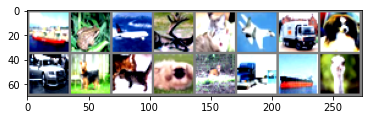

In [ ]:
# get some random training images
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) 
dataiter = iter(testloader)
# images = dataiter.next()
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

8.**Evaluate your final model on the test set**

Submit `predictions.npy` to Gradescope to see your model's performance on the test set.

**c. Secret test set [5 pts]**. We also have a secret test set containing 2000 images similar to CIFAR-10. We provide a helper function that saves your model predictions to a predictions.npy file. Submit the prediction for your best model to gradescope.

In your report, include: Test set accuracy (category-wise and aggregate) for your best model. You can get this from gradescope. A reasonable submission with more than 70% accuracy will be given full credit for this part.

In [ ]:
# run inference on the test set
predictions = run_secret_test(testloader, net, IS_GPU)
# save predictions
predictions = np.asarray(predictions)
np.save("Q1_label_predictions.npy", predictions)

## **Q2: Surface normal estimation**

Surface normal [40 pts]. In this part, you will build your own surface normal estimation model on a subset of the Taskonomy
dataset. This task comprises of predicting the normal vector at every pixel location. We will be using the mean and median
angular error as well as accuracy at 11.25$^{o},22.5, 22.5,22.5^{o},30, 30,30^{o}$ to measure performance. We provide code for computing these metrics.

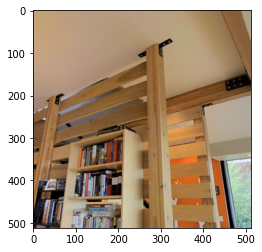

In [ ]:
plt.imshow(Image.open("point_1_view_6_domain_rgb.png"))

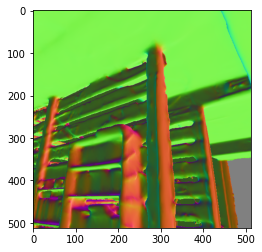

In [ ]:
plt.imshow(Image.open("point_1_view_6_domain_normal.png"))

Data. We have 400 images for training, and 200 images for testing. Each image is 128x128. We provide a basic data loader that you can build upon.

a) What you need to do **[15 pts]**:

1. **Implement training cycle**: Unlike Part 1 where we provided you with the training cycle, you will implement it all by yourself this time. Make sure you evaluate metrics and loss on the validation set every so often to check for overfitting.

2. **Build on top of ImageNet pre-trained Model**: Once you have a training cycle set up, you should design models for solving the task. To make training faster, we will build a model on top of a ResNet-18 1 model that has been pre-trained on the ImageNet dataset (via models.resnet18(pretrained=True)). These models are trained to predict the 1000 ImageNet object classes. To use this model for surface normal estimation, you will have to remove the **classifier and global average pooling layers**, and **stack on additional layers for surface normal estimation**. Note that, ResNet-18 model downsamples the input image by a factor of 32, remeber to upsample your prediction using **bilinear** interpolation. Since surface normal estimation is not a classification task anymore, you should also play with the loss function. Example of loss functions that you can try are: L1 loss, cosine similarity loss. You can refer to 2 3 for inspiration for how you can build on top of such pre-existing models. Again, carefully document the design choices you make in your report. We care most about the mean angular error out of these 5 metrics.

For the first part of Q2, we will allocate **10 out of 15 points** for the training cycle and model implementation. The **remaining 5 points** will be given for documenting the design choices and reporting of results.

Below is the performance of a very simple ResNet-18 model.

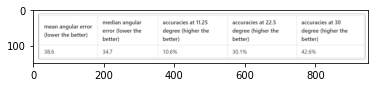

In [ ]:
plt.imshow(Image.open("baseline_result.png"))

Here are some sample prediction outputs using ResNet-18 model.

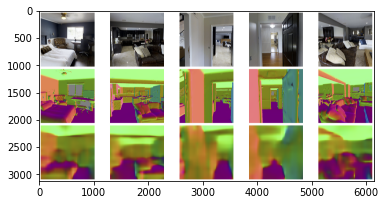

In [ ]:
plt.imshow(Image.open("visualization_r18.png"))

In your report, include: your model in the report by using Python print command print(net), and final performance on validation set (all 5 metrics).

**b. Increase your model output resolution [15 pts]**: The current model simply replaces the final fully connected layer in a ResNet-18 model for surface normal estimation. This still has a lot of draw backs. The most important factors that causes poor performance is the low output resolution. ResNet-18 model for image classification downsamples the input image by a factor of 32. In the previous step, we recover the resolution by a simple bilinear interpolation layer which upsamples the prediction by 32  times. In this part, our goal is to explore other choices to generate high-resolution predictions. We offer two choices that you can consider: 

- Atrous (or dilated) convolution. The concept of atrous convolution (or dilated convolution) is described it the DeepLab paper4. One way to think about atrous convolution is to think of running the network on shifted versions of the image and weaving the outputs together to produce an output at the original spatial resolution. This can be done simply by using the dilataion arguments in PyTorch. Refer to the paper [4] and PyTorch documentation for more detail.

- Building a learned upsampler.  Instead of using bilinear upsampling, you can use a decoder that learns to upsample
prediction to improve the output quality. The key that makes decoder works better than bilinear interpolation is the usage of
skip-connection.  Refer to the U-net [3] and DeepLabv3+ [5] for more detail.

You can implement either of these two choices, or other choices you find in other papers to increase your model output resolution. Please describe the methods you try in your report and report their performance. 

In your report, include:

- Your best model. Include final performance on validation set (5 metrics).
- An ablation table, listing all factors that you tried to make improvement to your final model as well as the validation performance.


We will allocate **10 out of 15 points** for the improvements made to model implementation. The **remaining 5 points** will be given for the writeup.

**c. Visualize your prediction [5 pts]**: In your report, visualize 5 predictions of your model on images that are not in the dataset. We provide functions to visualize arbitrary images. You just need to place your images under ./data/normal_visualization/images and run the appropriate code cell in colab. Take images of your choice and test the model with them. We also provide
some example images under normal_visualization. In your report, include: visualization of model prediction on five of your favorite indoor images visual comparisons of the output from part 2 and 3 on 2 images from the validation dataset, discuss your observations.

Download the data [taskonomy_resize_128_public.zip](https://drive.google.com/file/d/1EhaGeojCBgoYtsdilTbGd81-95VSgmAP/view?usp=sharing) and upload it to colab.



In [ ]:
!unzip -qqo /content/gdrive/MyDrive/Colab\ Notebooks/CS_585_PS2/data/taskonomy_resize_128_public.zip

In [ ]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [ ]:
# global variable
device = torch.device("cuda:0")

In [ ]:
class NormalDataset(data.Dataset):
    """
    Data loader for the Suface Normal Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    
    # def __init__(self, split="train", data_dir="./taskonomy_resize_128_public"):
    def __init__(self, split="train", data_dir="/content/gdrive/MyDrive/Colab Notebooks/CS_585_PS2/taskonomy_resize_128_public"):
        assert(split in ["train", "val"])
        split2name = {
            "train": "allensville",
            "val": "beechwood",
        }
        self.img_dir = os.path.join(data_dir, split2name[split] + "_rgb")
        self.gt_dir = os.path.join(data_dir, split2name[split] + "_normal")
        
        self.split = split
        self.filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*.png")
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + ".png")
        img = np.asarray(img).copy()
        gt = Image.open(os.path.join(self.gt_dir, filename.replace("_rgb", "_normal")) + ".png")
        gt = np.asarray(gt)

        # from rgb image to surface normal
        gt = gt.astype(np.float32) / 255
        gt = torch.Tensor(np.asarray(gt).copy()).permute((2, 0, 1))
        mask = self.build_mask(gt).to(torch.float)

        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        # normalize gt
        gt = gt * 2 - 1
        
        return img.contiguous(), gt, mask.sum(dim=0) > 0

    @staticmethod
    def build_mask(target, val=0.502, tol=1e-3):
        target = target.unsqueeze(0)
        if target.shape[1] == 1:
            mask = ((target >= val - tol) & (target <= val + tol))
            mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
            return (~mask).expand_as(target).squeeze(0)

        mask1 = (target[:, 0, :, :] >= val - tol) & (target[:, 0, :, :] <= val + tol)
        mask2 = (target[:, 1, :, :] >= val - tol) & (target[:, 1, :, :] <= val + tol)
        mask3 = (target[:, 2, :, :] >= val - tol) & (target[:, 2, :, :] <= val + tol)
        mask = (mask1 & mask2 & mask3).unsqueeze(1)
        mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
        return (~mask).expand_as(target).squeeze(0)

In [ ]:
##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration 
#from conference paper. The bottom line is that you will not just copy code from other repo
##########
class MyModel(nn.Module):

    def __init__(self): # feel free to modify input paramters
        super(MyModel, self).__init__()

        # TODO: define your model here
        self.resmodel = models.resnet18(pretrained=True)
        # nn.Conv2d(input channle dimension, output channel dimension, filter_size)

        self.resmodel = torch.nn.Sequential(*(list(self.resmodel.children())[:-2]))
        self.relu = nn.ReLU()
        # Channel: 3, input size = 32

        self.conv1  = nn.Conv2d(512, 256, 1)
        self.norm1  = nn.BatchNorm2d(256)
        # ---------------------------------------#
        self.conv2  = nn.Conv2d(256, 128, 1)
        self.norm2  = nn.BatchNorm2d(128)
        # ---------------------------------------#
        self.conv3  = nn.Conv2d(128, 64, 1)
        self.norm3  = nn.BatchNorm2d(64)
        # ---------------------------------------#
        self.conv4  = nn.Conv2d(64, 32, 1)
        self.norm4  = nn.BatchNorm2d(32)
        # ---------------------------------------#
        self.conv5  = nn.Conv2d(32, 3, 1)

        # ---------------------------------------#
        self.pool  = nn.MaxPool2d(2, stride=1)

    def forward(self, x): # feel free to modify input paramters

        # TODO: define your model here
        # bs, _,_ = x.shape()
        x = self.resmodel(x)
        x = self.relu(x)
        # ---------------------------------------#
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        # ---------------------------------------#
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        # ---------------------------------------#
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        # ---------------------------------------#
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu(x)

        x = self.conv5(x)

        x = nn.functional.interpolate(x, scale_factor = 32, mode = "bilinear")

        return x
print(MyModel())


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

MyModel(
  (resmodel): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
##########
#TODO: define your loss function here
##########
from torchvision.utils import draw_segmentation_masks
class MyCriterion(nn.Module):
    def __init__(self):
        super(MyCriterion, self).__init__()

    def forward(self, prediction, target, mask):
        # TODO implement
        # return (F.l1_loss(prediction, target, reduction="none") * mask.unsqueeze(1)).mean()
        return (F.mse_loss(prediction, target, reduction="none") * mask.unsqueeze(1)).mean()
        # return torch.masked_select(nn.L1Loss(prediction, target), mask)
        

In [ ]:
def simple_train(model, criterion, optimizer,  train_dataloader,scheduler = None, epoch = 15, train_bs = 8, test_bs = 256):
    
    # coding here
   ########################################################################
  # Tune the learning rate.
  # See whether the momentum and weight decay is useful or not
  IS_GPU = True
  TEST_BS = test_bs
  TRAIN_BS = train_bs
  train_dataset = NormalDataset(split='train')
  val_dataset = NormalDataset(split="val")

  # ---------
  num_epochs = epoch 
  # ---------

  train_loss_over_epochs = []
  val_accuracy_over_epochs = []

  # TODO !!!
  # consider reducing learning rate 


  # Implement training cycle: Unlike Part 1 where we provided you with the training 
  # cycle, you will implement it all by yourself this time. Make sure you evaluate 
  # metrics and loss on the validation set every so often to check for overfitting.



  # start training
  for epoch in tqdm(range(num_epochs), total=num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, Data in enumerate(train_dataloader, 0):
          # get the inputs
          # print(Data)
          inputs, labels, mask = Data
          # print(labels.size())
          mask = mask.reshape(train_bs,1,128,128)
          # print(mask)
          if IS_GPU:
              inputs = inputs.cuda()
              labels = labels.cuda()
              mask  = mask.cuda()
          
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          # print(model)
          outputs = model(inputs)
          # print("output size: ", outputs.size())
          # print("labels size: ", labels.size())
          # print("mask size: ", mask.size())
          
          loss = criterion(outputs, labels, mask)

          loss.backward()
          optimizer.step()
          
          # for i in optimizer.param_groups:
          #   print(i['lr'])
          # print statistics
          running_loss += loss.item()
      if scheduler is not None:
          scheduler.step()
      # Normalizing the loss by the total number of train batches
      running_loss/=len(train_dataloader)
      print('[%d] loss: %.3f' %
            (epoch + 1, running_loss))

      # Calculate loss of the existing model
      train_loss_over_epochs.append(running_loss)


# Training cycle


In [ ]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation 
# dataset and compute evaluation metrics every so often. 
# You may also want to save models that perform well.

model = MyModel().to(device)
# model = resmodel.to(device)


criterion = MyCriterion().to(device)

import torch.optim as optim

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
IS_GPU = True
TEST_BS = 256
TRAIN_BS = 8

# # ---------
optimizer = optim.SGD(model.parameters(), lr=0.12, momentum=0.9, weight_decay=0.)  # TODO
# # ---------
train_dataset = NormalDataset(split='train')
val_dataset = NormalDataset(split="val")

train_dataloader = data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)

simple_train(model, criterion, optimizer, train_dataloader, epoch = 30)

# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE
# ---------
num_epochs = 9 ## TODO
# ---------

train_loss_over_epochs = []
val_accuracy_over_epochs = []


# # start training
# for epoch in tqdm(range(num_epochs), total=num_epochs):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, Data in enumerate(train_dataloader, 0):
#         # get the inputs
#         # print(Data)
#         inputs, labels, mask = Data
#         # print(labels.size())
#         mask = mask.reshape(8,1,128,128)
#         # print(mask)
#         if IS_GPU:
#             inputs = inputs.cuda()
#             labels = labels.cuda()
#             mask  = mask.cuda()
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         # print(model)
#         outputs = model(inputs)
#         # print("output size: ", outputs.size())
#         # print("labels size: ", labels.size())
#         # print("mask size: ", mask.size())
        
#         loss = criterion(outputs, labels, mask)

#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
    
#     # Normalizing the loss by the total number of train batches
#     running_loss/=len(train_dataloader)
#     print('[%d] loss: %.3f' %
#           (epoch + 1, running_loss))
#     train_loss_over_epochs.append(running_loss)
#     # val_accuracy_over_epochs.append(val_accuracy.cpu())

NameError: ignored

In [40]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta//2
    return tensor[:,:, delta:tensor_size - delta:tensor_size-delta]
    
class unet(nn.Module):
    def __init(self, ):
        super(unet, self).__init__()

        self.maxPol = nn.Maxpool(kernal_size=2, stride= 2)
        self.down_conv1 = double_conv(3, 64)
        self.down_conv2 = double_conv(64, 128)
        self.down_conv3 = double_conv(128, 256)
        self.down_conv4 = double_conv(256, 512)

        self.up_convT1 = nn.ConvTranspose2d(512, 256, 2, stride = 2)


    def forward(self, x):
        x0 = self.down_conv1(x)
        x1 = self.maxPol(x0)
        x1 = self.down_conv2(x1)
        x2 = self.maxPol(x1)
        x2 = self.down_conv3(x2)
        x3 = self.maxPol(x2)
        x3 = self.down_conv4(x3)
        print(x3.size())
        x4 = self.up_convT1(x3)
        print(x4.size())
        return



In [38]:
from torch.nn.modules.activation import ReLU
# b. Increase your model output resolution [15 pts]: The current model simply replaces 
# the final fully connected layer in a ResNet-18 model for surface normal estimation. This 
# still has a lot of draw backs. The most important factors that causes poor performance 
# is the low output resolution. ResNet-18 model for image classification downsamples the 
# input image by a factor of 32. In the previous step, we recover the resolution by a simple 
# bilinear interpolation layer which upsamples the prediction by 32 times. In this part, 
# our goal is to explore other choices to generate high-resolution predictions. We offer 
# two choices that you can consider:

# Building a learned upsampler. Instead of using bilinear upsampling, you can use a decoder 
# that learns to upsample prediction to improve the output quality. The key that makes decoder 
# works better than bilinear interpolation is the usage of skip-connection. Refer to the U-net [3] 
# and DeepLabv3+ [5] for more detail.

class convNorm(nn.Module):
    def __init__(self, inChannel, outChannel, filter_size): # feel free to modify input paramters
        super(convNorm, self).__init__()
        self.convNorm = nn.Sequential(
            nn.Conv2d(inChannel, outChannel, filter_size), 
            nn.BatchNorm2d(outChannel),
            nn.ReLU()
            )

    def forward(self, x):
        return self.convNorm(x)
class convNormT(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros'): # feel free to modify input paramters
        super(convNormT, self).__init__()
        self.convNormT = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, dilation = dilation), 
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU()
            )

    def forward(self, x):
        return self.convNormT(x)

def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv


def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta//2
    return tensor[:,:, delta:tensor_size - delta:tensor_size-delta]

class bModel(nn.Module):

    def __init__(self):
        super(bModel, self).__init__()
        self.relu = nn.ReLU()
        
        self.resmodel = models.resnet18(pretrained=True)
        print(self.resmodel)

        self.conv0 = nn.Sequential(
            self.resmodel.conv1,
            self.resmodel.bn1,
            self.resmodel.relu,
            )
        self.down1  = self.resmodel.maxpool
        self.conv1 = self.resmodel.layer1
        self.conv2 = self.resmodel.layer2
        self.conv3 = self.resmodel.layer3
        self.conv4 = self.resmodel.layer4


        self.resmodel = torch.nn.Sequential(*(list(self.resmodel.children())[:-2]))
        # ------------------ 1 ------------------

        # self.convT1    = convNormT(3, 3, 2, dilation=2, stride = 2, padding = 1, output_padding  =1 )
        # self.convT2    = convNormT(3, 3, 2, dilation=2, stride = 2, padding = 1, output_padding  =1 )
        # self.convT3    = convNormT(3, 3, 2, dilation=2, stride = 2, padding = 1, output_padding  =1 )
        # self.convT4    = convNormT(3, 3, 2, dilation=2, stride = 2, padding = 1, output_padding  =1 )
        # self.convT5    = convNormT(3, 3, 2, dilation=2, stride = 2, padding = 1, output_padding  =1 )
        
        # ------------------ 2 ------------------
        self.convT1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=3,
            stride=2,
            padding=0,
            dilation=2,
        )
        self.convT1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=3,
            stride=2,
            padding=0,
            dilation=2,
        )
        

        self.convT2 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=0,
            dilation=2,
            output_padding=1
        )
        self.convT3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=32,
            kernel_size=5,
            stride=2,
            padding=0,
            dilation=2,
            output_padding=1,
        )
        self.convT4 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=3,
            kernel_size=5,
            stride=2,
            padding=0,
            dilation=2,
            output_padding=1,
        )



        # ------------------ 3 ------------------
        # self.convNormT5 = nn.ConvTranspose2d(512, 256, 1)
        # self.convNormT4 = nn.ConvTranspose2d(256, 128, 1)
        # self.convNormT3 = nn.ConvTranspose2d(128, 64, 1)
        # self.convNormT2 = nn.ConvTranspose2d(64, 32, 1)
        # self.convNormT1 = nn.ConvTranspose2d(32, 3, 1)
        # ------------------ 4 ------------------
        # self.up_trans1 = nn.ConvTranspose2d(
        #     in_channels = 512,
        #     out_channels= 256,
        #     kernel_size=2,
        #     stride=2
        # )
        # self.up_conv_1 = double_conv(512, 256)

    def forward(self, x): 
        print(x.size())
        # x = self.resmodel(x)
        # print(x.size())
        # x = self.relu(x)
        x0 = self.conv0(x)
        print("0: ", x0.size())
        x1 = self.down1(x0)
        x1 = self.conv1(x1)
        print("1: ", x1.size())
        x2 = self.conv2(x1)
        print("2: ", x2.size())
        x3 = self.conv3(x2)
        print("3: ", x3.size())
        x4 = self.conv4(x3)
        print("4: ", x4.size())


        # x = self.up_trans1(x)
        # x = 


        # print("before: ", x.size())
        # x = self.convNorm1(x)
        # # print("1: ", x.size())
        # x = self.convNorm2(x)
        # # print("2: ", x.size())
        # x = self.convNorm3(x)
        # # print("3: ", x.size())
        # x = self.convNorm4(x)
        # print("4: ",x.size())
        # x = self.convNorm5(x)
        # print("5: ",x.size())
        # x = self.conv5(x)

        # ------------------ 1 ------------------
        # x = self.convT1(x)
        # x = self.convT2(x)
        # x = self.convT3(x)
        # x = self.convT4(x)
        # x = self.convT5(x)
        # ------------------ 2 ------------------
        # print("size: ", x.size())

        x = self.convT1(x)
        x = self.relu(x)
        # print("convT1: ",x.size())
        x = self.convT2(x)
        x = self.relu(x)
        # print("convT2: ",x.size())
        x = self.convT3(x)
        x = self.relu(x)
        # print("convT3: ",x.size())
        x = self.convT4(x)
        # ------------------ 3 ------------------
        # x = self.convNormT1(x)
        # x = self.relu(x)
        # x = self.convNormT2(x)
        # x = self.relu(x)
        # x = self.convNormT3(x)
        # x = self.relu(x)
        # x = self.convNormT4(x)
        # x = self.relu(x)
        # x = self.convNormT5(x)

        # ------------------ 4 ------------------
        # x = self.tconv1(x)
        # x = self.tconv2(x)
        # x = self.tconv3(x)
        # x = self.tconv4(x)
        # print("size: ", x.size())
        # x = self.convNorm5(x)
        # x = x[:, :, :128, :128]  # Crop output to desired size
        # torch.Size([8, 3, 4, 4])

        # print("size: ", x.size())

        # for i in range(5):
        #     x = self.convT1(x)
        #     print(x.size())

        # print("1 convt size: ", x.size())
        # x = self.convT1(x)
        # print("2 convt size: ", x.size())
        # x = self.convT1(x)
        # x = self.convT3(x)

        # print("output size: ", x.size())
        # Suppose to be torch.Size([8, 3, 128, 128])
        return x

In [ ]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [42]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# model = bModel().to(device)
# model = MyModel().to(device)
model = unet().to(device)
print(model)
# print()

criterion = MyCriterion().to(device)

IS_GPU = True
TEST_BS = 256
TRAIN_BS = 8

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)  # TODO
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_dataset = NormalDataset(split='train')
val_dataset = NormalDataset(split="val")

train_dataloader = data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)

# simple_train(model, criterion, optimizer, train_dataloader, epoch = 10)

simple_train(model, criterion, optimizer, train_dataloader, scheduler = scheduler, epoch = 30, train_bs =TRAIN_BS, test_bs = TEST_BS)

unet()


ValueError: ignored

# You do not need to change anything below

In [ ]:
########################################################################
# Evaluate your result, and report
# 1. Mean angular error
# 2. Median angular error
# 3. Accuracy at 11.25 degree
# 4. Accuracy at 22.5 degree
# 5. Accuracy at 30 degree
# using provided `simple_predict` function.
from PIL import Image
def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask.unsqueeze(1)).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
print("Validation loss (L1):", np.mean(val_losses))
print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
    np.average(val_total_normal_errors), np.median(val_total_normal_errors),
    np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
))

# vis validation
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(val_gts[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(val_preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# Visualization
# pick some of your favorite images and put them under `./data/normal_visualization/image`

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./taskonomy_resize_128_public", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext

        self.img_dir = os.path.join(image_dir, "collierville_rgb") 
        
        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        
        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_public")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

imgs, preds = simple_vis(model)
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(imgs[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')

d) **Secret test set [5 pts]** - Use the code provided below to use your trained model to generate predictions for a secret test set. Please submit the generated Q2_surface_predictions.npy

In [ ]:
# Test your model on the test set, submit the output to gradescope

from PIL import Image
import numpy as np

def simple_test(model, out_dir):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_public")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)

    saved_predictions = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, filename = batch
            img = img.to(device)

            pred = model(img)
            saved_predictions.append(pred.cpu())

        saved_predictions = torch.cat(saved_predictions, dim=0)
        return saved_predictions

out_dir = "Q2_normal_predictions"
saved_predictions = simple_test(model, out_dir)
np.save('./Q2_surface_predictions.npy', saved_predictions)